# 1. Preprocsssing

In [2]:
import pandas as pd
import numpy as np

In [3]:
# Read the csv file
raw_data = pd.read_csv('dataset/raw_data.csv')

# Drop the columns that are not needed
columns_to_drop = [
    'name', 'description', 'neighborhood_overview', 'picture_url', 
    'listing_url', 'scrape_id', 'last_scraped', 'source', 'host_id', 'host_url', 'host_name', 
    'host_since', 'host_location', 'host_about', 'host_response_time', 
    'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 
    'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 
    'host_listings_count', 'host_total_listings_count', 'host_verifications', 
    'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
    'neighbourhood_group_cleansed', 'bathrooms', 'maximum_nights', 'minimum_minimum_nights', 
    'maximum_minimum_nights', 'minimum_maximum_nights', 
    'maximum_maximum_nights', 'minimum_nights_avg_ntm', 
    'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability', 
    'availability_30', 'availability_60', 'availability_90', 
    'availability_365', 'calendar_last_scraped', 'number_of_reviews', 
    'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review', 
    'last_review', 'review_scores_rating', 'review_scores_accuracy', 
    'review_scores_cleanliness', 'review_scores_checkin', 
    'review_scores_communication', 'review_scores_location', 
    'review_scores_value', 'license', 'instant_bookable', 
    'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 
    'calculated_host_listings_count_private_rooms', 
    'calculated_host_listings_count_shared_rooms', 'reviews_per_month'
]

raw_data = raw_data.drop(columns=columns_to_drop, axis=1)

# Remove the dollar sign and convert to integer
raw_data['price'] = raw_data['price'].replace('[\$,]', '', regex=True).str.split('.', expand=True)[0].astype(int)
# Remove the data with price = 0 and higher than 200000
raw_data = raw_data[raw_data['price'] > 0]
raw_data = raw_data[raw_data['price'] < 100000]

# Export csv for data visualization
raw_data.to_csv('dataset/cleaned_data.csv', index=False)

In [4]:
raw_data.head()

,id,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights
0,197677,Sumida Ku,35.71707,139.82608,Entire rental unit,Entire home/apt,2,1 bath,1.0,2.0,"[""Microwave"", ""Hangers"", ""Kitchen"", ""Fire exti...",12000,3
1,5240174,Shibuya Ku,35.66339,139.68741,Entire rental unit,Entire home/apt,4,1 bath,NaN,1.0,"[""First aid kit"", ""Stove"", ""Hangers"", ""Bed lin...",9264,2
2,5262640,Nakano Ku,35.73445,139.63139,Entire rental unit,Entire home/apt,2,1 bath,1.0,1.0,"[""Kitchen"", ""TV"", ""Fire extinguisher"", ""Essent...",7419,3
3,776070,Kita Ku,35.73844,139.76917,Private room in home,Private room,1,1 shared bath,NaN,1.0,"[""Luggage dropoff allowed"", ""Private entrance""...",8902,3
4,905944,Shibuya Ku,35.67878,139.67847,Entire rental unit,Entire home/apt,6,1 bath,2.0,4.0,"[""Japan available brand conditioner"", ""Microwa...",23740,3


### Download images of each accommodation

### split the data into train and test dataset

In [5]:
from sklearn.model_selection import train_test_split
# split the data into train and test
train, test = train_test_split(raw_data, test_size=0.2, random_state=42)

# 2. EDA + Feature Engineering

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [ ]:
plt.figure(figsize=(12, 6))

sns.histplot(train['price'], bins=500)
plt.xlim(0, 100000)  # Set the x-axis limit
plt.title('Histogram of Price')
plt.xlabel('Price')
plt.ylabel('Frequency')


### Neighbourhood (area)

/Users/shinichimoribe/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/shinichimoribe/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/shinichimoribe/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(0.0, 60000.0)

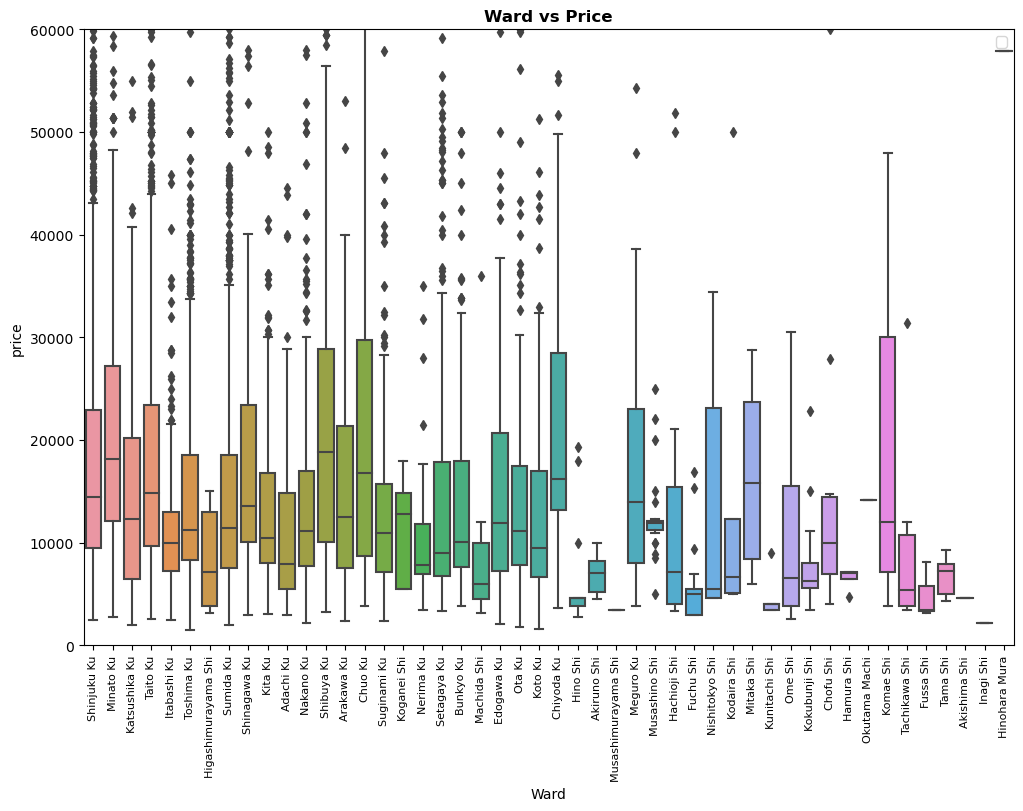

In [8]:
plt.figure(figsize=(12,8))
ax = sns.boxplot(x='neighbourhood_cleansed', y='price', data=train)
ax.set(xlabel='Ward', ylabel='price')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, size=8)
ax.set_title("Ward vs Price", size=12, weight='bold')
ax.legend(fontsize=10)
ax.set_ylim(0, 60000)

In [ ]:
plt.figure(figsize=(12, 8))
sns.countplot(y='neighbourhood_cleansed', data=train, order=train['neighbourhood_cleansed'].value_counts().index)

plt.title('Count of Occurrences by Neighbourhood')
plt.xlabel('Count')
plt.ylabel('Neighbourhood')

In [10]:
# extract Ku cities
ku_cities = train['neighbourhood_cleansed'][train['neighbourhood_cleansed'].str.endswith('Ku')].unique()
# make dummy variables of Ku cities
for city in ku_cities:
    train[city] = train['neighbourhood_cleansed'].apply(lambda x: 1 if x == city else 0)
    test[city] = test['neighbourhood_cleansed'].apply(lambda x: 1 if x == city else 0)

### latitude	longitude

In [11]:
import plotly.express as px
fig = px.scatter_mapbox(train, lat="latitude", lon="longitude", color="price", color_continuous_scale=px.colors.cyclical.IceFire, mapbox_style="carto-positron")
fig.show()

### Distance to the closest station

In [12]:
# import railway station data
df_station = pd.read_csv('dataset/station20230907free.csv')
df_station.head()
df_station_tokyo = df_station[df_station['pref_cd'] == 13]
df_station_tokyo.head()

,station_cd,station_g_cd,station_name,station_name_k,station_name_r,line_cd,pref_cd,post,address,lon,lat,open_ymd,close_ymd,e_status,e_sort
1265,1130101,1130101,東京,NaN,NaN,11301,13,100-0005,東京都千代田区丸の内一丁目,139.766103,35.681391,0000-00-00,0000-00-00,0,1130101
1266,1130102,1130102,新橋,NaN,NaN,11301,13,105-0004,東京都港区新橋二丁目17,139.758587,35.666195,0000-00-00,0000-00-00,0,1130102
1267,1130103,1130103,品川,NaN,NaN,11301,13,108-0074,東京都港区高輪三丁目26-27,139.738999,35.628760,0000-00-00,0000-00-00,0,1130103
1286,1130201,1130201,大崎,NaN,NaN,11302,13,141-0032,東京都品川区大崎一丁目21-4,139.728439,35.619772,1901-02-25,0000-00-00,0,1130201
1287,1130202,1130202,五反田,NaN,NaN,11302,13,141-0022,東京都品川区東五反田一丁目26,139.723822,35.625974,1911-10-15,0000-00-00,0,1130202


In [13]:
import plotly.express as px
fig = px.scatter_mapbox(df_station_tokyo, lat="lat", lon="lon", color_continuous_scale=px.colors.cyclical.IceFire, mapbox_style="carto-positron")
fig.show()

In [14]:
from geopy.distance import geodesic

def get_distance(lat, lon, df_station):
    distances = []
    for idx, row in df_station.iterrows():
        distances.append(geodesic((lat, lon), (row['lat'], row['lon'])).km)
    return min(distances)

# get the nearest station
train['distance_to_station'] = train.apply(lambda x: get_distance(x['latitude'], x['longitude'], df_station_tokyo), axis=1)
test['distance_to_station'] = test.apply(lambda x: get_distance(x['latitude'], x['longitude'], df_station_tokyo), axis=1)

In [15]:
# get the distance to Tokyo station
tokyo_station = [35.681236, 139.767125]

#get the distance to Shinjuku station
shinjuku_station = [35.690921, 139.700257]


# Calculate the distance to Tokyo station for each row in the DataFrame
train['distance_to_tokyo_station'] = train.apply(lambda row: geodesic((row['latitude'], row['longitude']), tokyo_station).km, axis=1)
test['distance_to_tokyo_station'] = test.apply(lambda row: geodesic((row['latitude'], row['longitude']), tokyo_station).km, axis=1)
train['distance_to_shinjuku_station'] = train.apply(lambda row: geodesic((row['latitude'], row['longitude']), shinjuku_station).km, axis=1)
test['distance_to_shinjuku_station'] = test.apply(lambda row: geodesic((row['latitude'], row['longitude']), shinjuku_station).km, axis=1)


#### property and room type

In [ ]:
plt.figure(figsize=(12, 8))
sns.countplot(y='property_type', data=train, order=train['property_type'].value_counts().index)

plt.title('Count of Occurrences by property_type')
plt.xlabel('Count')
plt.ylabel('property_type')

# use only room type in this project


In [ ]:
sns.countplot(y='room_type', data=train, order=train['room_type'].value_counts().index)
plt.title('Count of Occurrences by room_type')
plt.xlabel('Count')
plt.ylabel('room_type')

In [18]:
# extract room_type
room_type = train['room_type'].unique()
# make dummy variables of room_type
for room in room_type:
    train[room] = train['room_type'].apply(lambda x: 1 if x == room else 0)
    test[room] = test['room_type'].apply(lambda x: 1 if x == room else 0)


### creating variables for bathrooms

In [19]:
train['bathrooms_text'].value_counts()
import re
# Convert 'bathrooms_text' column to strings
train['bathrooms'] = train['bathrooms_text'].astype(str).apply(lambda x: 0.5 if 'half' in x.lower() else (re.search(r'\d*\.?\d+', x).group() if re.search(r'\d*\.?\d+', x) else 0)).astype(float)
test['bathrooms'] = test['bathrooms_text'].astype(str).apply(lambda x: 0.5 if 'half' in x.lower() else (re.search(r'\d*\.?\d+', x).group() if re.search(r'\d*\.?\d+', x) else 0)).astype(float)
train['bathrooms_shared'] = train['bathrooms_text'].astype(str).apply(lambda x: 1 if 'share' in x.lower() else 0)
test['bathrooms_shared'] = test['bathrooms_text'].astype(str).apply(lambda x: 1 if 'share' in x.lower() else 0)

### creating variables for amenities

In [20]:
from collections import Counter

# Extract and flatten the amenities from the 'amenities' column
all_amenities = [amenity.replace('[', '').replace(']', '').replace('"', '') 
                 for amenities in train['amenities'].astype(str) 
                 for amenity in amenities.split(', ')]

# Use Counter to count the occurrences of each amenity
amenities_count = Counter(all_amenities)
amenities_count.most_common(50)

[('Hair dryer', 9338),
 ('Smoke alarm', 9233),
 ('Essentials', 9134),
 ('Wifi', 8875),
 ('Shampoo', 8725),
 ('Hangers', 8419),
 ('Fire extinguisher', 8163),
 ('Kitchen', 8109),
 ('Hot water', 8078),
 ('Air conditioning', 8014),
 ('Refrigerator', 7838),
 ('Microwave', 7576),
 ('Heating', 7406),
 ('Dishes and silverware', 7320),
 ('Self check-in', 6260),
 ('Long term stays allowed', 6229),
 ('Washer', 6096),
 ('Bed linens', 5851),
 ('TV', 5679),
 ('Iron', 5500),
 ('Carbon monoxide alarm', 5329),
 ('Hot water kettle', 5157),
 ('Conditioner', 5065),
 ('Bathtub', 5046),
 ('Body soap', 4749),
 ('Private entrance', 4692),
 ('Cooking basics', 4622),
 ('Cleaning products', 4255),
 ('Room-darkening shades', 4233),
 ('Dedicated workspace', 4185),
 ('Stove', 3656),
 ('Lockbox', 3526),
 ('Bidet', 3438),
 ('Elevator', 3416),
 ('Security cameras on property', 3269),
 ('Freezer', 3129),
 ('Rice maker', 2984),
 ('Luggage dropoff allowed', 2964),
 ('First aid kit', 2608),
 ('Dining table', 2597),
 ('Sho

In [21]:
# create dummy variables for the top 50 amenities
for amenity in amenities_count.most_common(50):
    train[amenity[0]] = train['amenities'].astype(str).apply(lambda x: 1 if amenity[0] in x else 0)
    test[amenity[0]] = test['amenities'].astype(str).apply(lambda x: 1 if amenity[0] in x else 0)

### Drop the columns that are not needed

In [22]:
# Drop the columns that are not needed
train.drop(['neighbourhood_cleansed', 'property_type', 'room_type', 'bathrooms_text', 'amenities'], axis=1, inplace=True)
test.drop(['neighbourhood_cleansed',  'property_type', 'room_type', 'bathrooms_text', 'amenities'], axis=1, inplace=True)

### treatment for missing values

In [23]:
# check the missing values
train.isnull().sum().sort_values(ascending=False).head(5)

bedrooms          1665
beds               445
id                   0
Bed linens           0
Cooking basics       0
dtype: int64

In [24]:
# fill the missing values with -1
train.fillna(-1, inplace=True)
test.fillna(-1, inplace=True)

### correlation matrix

<Axes: >

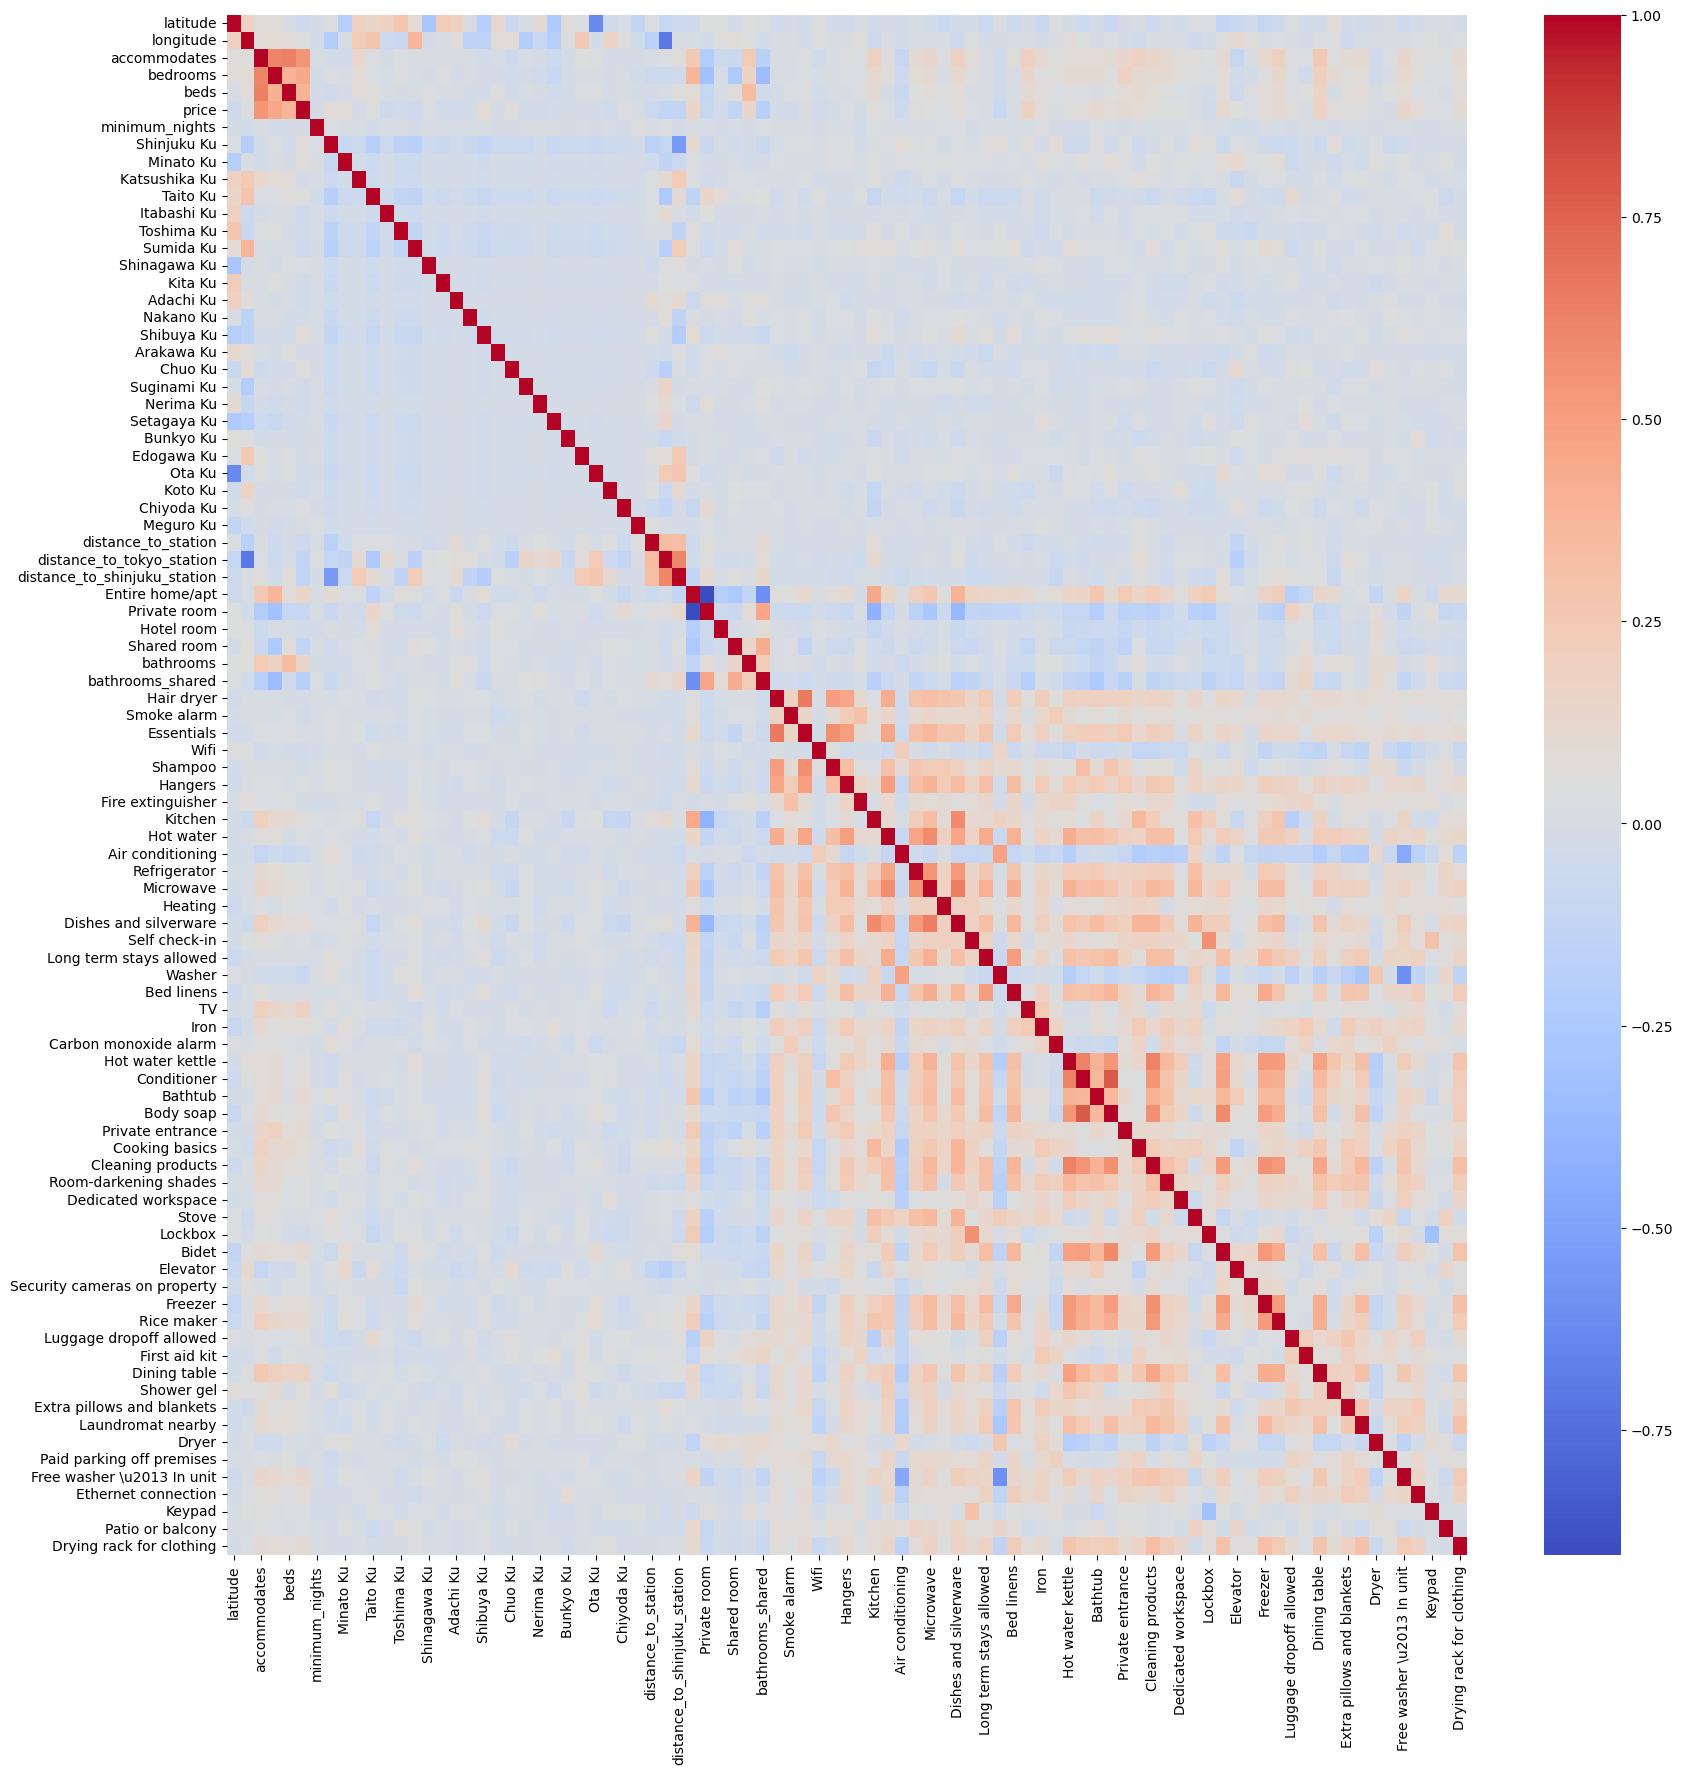

In [25]:
# create correlation matrix
corr = (train.drop(['id'], axis=1)).corr()
# plot the heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(corr, cmap='coolwarm')

### export datasets

In [26]:
# export the datasets
train.to_csv('dataset/train.csv', index=False)
test.to_csv('dataset/test.csv', index=False)

In [27]:
# import the datasets
train = pd.read_csv('dataset/train.csv')
test = pd.read_csv('dataset/test.csv')

# 3. Baseline Model with RF

In [28]:
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)
X_train = train.drop(['id','price'], axis=1)
y_train = train['price']
X_test = test.drop(['id','price'], axis=1)
y_test = test['price']

In [29]:
from sklearn.ensemble import RandomForestRegressor

In [30]:
# Random Forest Regressor
random_forest_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest_regressor.fit(X_train, y_train)

# Predict the price
y_pred = random_forest_regressor.predict(X_test)


In [ ]:
# Scatter plot of actual vs predicted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Prices (Random Forest Regressor)")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2, label='Ideal Prediction')

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')


In [33]:
# import shap

# # Create object that can calculate shap values
# explainer = shap.Explainer(random_forest_regressor)
# shap_values = explainer.shap_values(X_train)

# # Plot summary_plot
# shap.summary_plot(shap_values, X_train) # max_display=20

# 4. XGBoost with Optuna

In [34]:
import xgboost
import optuna
from sklearn.metrics import mean_squared_error

In [35]:
def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.01, 1.0),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
        'random_state': trial.suggest_int('random_state', 1, 1000)
    }
    model = xgboost.XGBRegressor(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return mean_squared_error(y_test, y_pred)

In [ ]:
# Create the study
study = optuna.create_study(direction='minimize', study_name='regression')
study.optimize(objective, n_trials=50)

In [ ]:
# Get the best parameters
best_params = study.best_params
#prediction
model = xgboost.XGBRegressor(**best_params)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [ ]:
# Scatter plot of actual vs predicted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Prices (XGBoost Regressor)")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2, label='Ideal Prediction')

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')

In [40]:
# # save the model
# import pickle
# pickle.dump(model, open('model.sav','wb'))

In [41]:
# # import model
# import pickle
# model = pickle.load(open('model.sav','rb'))